In [1]:
# add parent directory to path: enable import from parent dir
import sys
sys.path.append('../')

from environment import SmartBrokerEnv
from agents.a2c import A2C
from networks.a2c.actor import Actor
from networks.a2c.critic import Critic
from networks.a2c_lstm.actor import ActorLSTM
from networks.a2c_lstm.critic import CriticLSTM

import gym
import matplotlib.pyplot as plt
import torch

In [2]:
norm_cols = ['Volume XRP']
cols = ['date'] + ['open', 'high', 'low', 'close', f'Volume XRP']
batch_dur = 30
env = SmartBrokerEnv(
    batch_dur=batch_dur,
    df_info={
        'start_date': '2021-01-01',
        'end_date': '2021-02-01',
        'norm_cols': norm_cols,
        'cols': cols,
    },
    portfolio={

    },
)

/Users/vinay/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/vinay/code/git/smart-broker/notebooks/../environment.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['rolling_price'] = self.df[self.price_typ].rolling(self.roll_period).sum()
/Users/vinay/miniforge3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [7]:
actor_model = ActorLSTM(
    state_dim=batch_dur*3+3,
    action_dim=3,
)
critic_model = Critic(state_dim=batch_dur*3+3)
a2c = A2C(
    env=env, 
    actor=actor_model,
    critic=critic_model,
    n_actns=3,
    actor_optmz=torch.optim.Adam(actor_model.parameters(), lr=0.001),
    critic_optmz=torch.optim.Adam(critic_model.parameters(), lr=0.001),
    hyprprms={
        'gamma': 0.9995,
    },
    log_freq=25,
    p_net_type='lstm',
    c_net_type='nn',
)

In [4]:
a2c.run(5000)


Ep: 0 | L: 1.211 | R: 0.55 | P: 3.57 | R.Avg P: 3.57 | NW: 103.57 | R.Avg NW: 103.57 | R.U: 227
Ep: 25 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.99 | NW: 100.0 | R.Avg NW: 100.99 | R.U: 109
Ep: 50 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.47 | NW: 100.0 | R.Avg NW: 100.47 | R.U: 63
Ep: 75 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.11 | NW: 100.0 | R.Avg NW: 100.11 | R.U: 24
Ep: 100 | L: 0.992 | R: 0.53 | P: 0.0 | R.Avg P: 0.08 | NW: 100.0 | R.Avg NW: 100.08 | R.U: 14
Ep: 125 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.21 | NW: 100.0 | R.Avg NW: 100.21 | R.U: 34
Ep: 150 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.56 | NW: 100.0 | R.Avg NW: 100.56 | R.U: 80
Ep: 175 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 0.66 | NW: 100.0 | R.Avg NW: 100.66 | R.U: 96
Ep: 200 | L: 0.989 | R: 0.55 | P: 2.96 | R.Avg P: 1.48 | NW: 102.96 | R.Avg NW: 101.48 | R.U: 192
Ep: 225 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg P: 1.37 | NW: 100.0 | R.Avg NW: 101.37 | R.U: 175
Ep: 250 | L: 0.998 | R: 0.53 | P: 0.0 | R.Avg 

KeyboardInterrupt: 

## Visualizations

### Traning 

Text(0.5, 1.0, 'Rolling avg balance per episode')

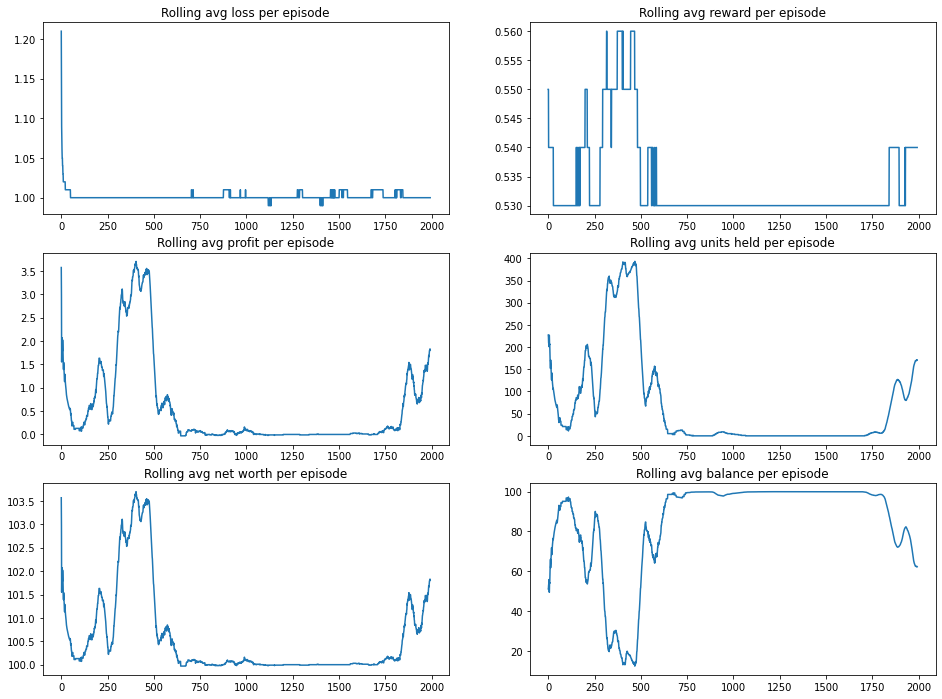

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
r_avg_rewards = []
r_avg_profits = []
r_avg_bal = []
r_avg_units_held = []
r_avg_loss = []
r_avg_net_worth = []
count = 0

for _, log in a2c.logs.items():
    r_avg_rewards.append(log['r_avg_reward'])
    r_avg_profits.append(log['r_avg_profit'])
    r_avg_bal.append(log['r_avg_bal'])
    r_avg_units_held.append(log['r_avg_units_held'])
    r_avg_loss.append(log['r_avg_loss'])
    r_avg_net_worth.append(log['r_avg_net_worth'])
    count += 1

ax[0][0].plot(range(count), r_avg_loss)
ax[0][0].set_title('Rolling avg loss per episode')

ax[0][1].plot(range(count), r_avg_rewards)
ax[0][1].set_title('Rolling avg reward per episode')

ax[1][0].plot(range(count), r_avg_profits)
ax[1][0].set_title('Rolling avg profit per episode')

ax[1][1].plot(range(count), r_avg_units_held)
ax[1][1].set_title('Rolling avg units held per episode')

ax[2][0].plot(range(count), r_avg_net_worth)
ax[2][0].set_title('Rolling avg net worth per episode')

ax[2][1].plot(range(count), r_avg_bal)
ax[2][1].set_title('Rolling avg balance per episode')

In [ ]:
# torch.save(a2c.actor.state_dict(), '../models/a2c_cl_an/actor')
# torch.save(a2c.critic.state_dict(), '../models/a2c_cl_an/critic')

In [ ]:
import pickle
from datetime import datetime

temp = dict(a2c.logs)
with open(f"../pickles/a2c_logs_{datetime.now()}.pickle","wb") as f:
    pickle.dump(temp, f, pickle.HIGHEST_PROTOCOL)

### Observations

- A2C performs well when actor is chained with LSTM and critic with Neural Network
- If the actor is chained with Neural Network we dont seem to learn the task